# DenseNet Architecture

In [1]:
import pathlib

import tensorflow as tf
from bcd.model.factory import DenseNetFactory
from bcd.model.visual import learning_curve

In [2]:
batch_size = 32
initial_epochs = 5
train_dir_10 = pathlib.Path("data/image/1_final/training_10/training/").with_suffix('')
test_dir = pathlib.Path("data/image/1_final/test/test/").with_suffix('')
checkpoint_path = "models/checkpoints/densenet.ckpt"

## Load Data

In [3]:
# Training DataSet (10%)
train_ds_10 = tf.keras.utils.image_dataset_from_directory(
    train_dir_10,
    labels="inferred",
    color_mode="rgb",
    image_size=(224,224),
    shuffle=True,
    validation_split=0.2,
    subset='training',
    interpolation="bilinear",
    seed=123,
    batch_size=batch_size)

# Validation DataSet (10%)
val_ds_10 = tf.keras.utils.image_dataset_from_directory(
    train_dir_10,
    labels="inferred",
    color_mode="rgb",
    image_size=(224,224),
    shuffle=True,
    validation_split=0.2,
    subset='validation',
    interpolation="bilinear",
    seed=123,
    batch_size=batch_size)

# Test Set
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    color_mode="rgb",
    image_size=(224,224),
    shuffle=True)

Found 276 files belonging to 2 classes.
Using 221 files for training.
Found 276 files belonging to 2 classes.
Using 55 files for validation.
Found 649 files belonging to 2 classes.


## Callbacks

In [4]:
# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True, # set to False to save the entire model
                                                         save_best_only=True, # save only the best model weights instead of a model every epoch
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1)

## Feature Extraction

In [5]:
factory = DenseNetFactory()
densenet_1 = factory.create()
densenet_1_history = densenet_1.fit(train_ds_10, epochs=initial_epochs, validation_data=val_ds_10, callbacks=[checkpoint_callback])

Epoch 1/5
7/7 [==============================] - ETA: 0s - loss: 0.6844 - accuracy: 0.5656
Epoch 1: val_loss improved from inf to 0.63521, saving model to models/checkpoints/densenet.ckpt
7/7 [==============================] - 63s 7s/step - loss: 0.6844 - accuracy: 0.5656 - val_loss: 0.6352 - val_accuracy: 0.6182
Epoch 2/5
7/7 [==============================] - ETA: 0s - loss: 0.6742 - accuracy: 0.5656
Epoch 2: val_loss did not improve from 0.63521
7/7 [==============================] - 41s 6s/step - loss: 0.6742 - accuracy: 0.5656 - val_loss: 0.6358 - val_accuracy: 0.6182
Epoch 3/5
7/7 [==============================] - ETA: 0s - loss: 0.6679 - accuracy: 0.6244
Epoch 3: val_loss did not improve from 0.63521
7/7 [==============================] - 44s 6s/step - loss: 0.6679 - accuracy: 0.6244 - val_loss: 0.6412 - val_accuracy: 0.5818
Epoch 4/5
7/7 [==============================] - ETA: 0s - loss: 0.6770 - accuracy: 0.5837
Epoch 4: val_loss did not improve from 0.63521
7/7 [============

Evaluate on test data.

In [6]:
results_1 = densenet_1.evaluate(test_ds)
results_1

21/21 [==============================] - 105s 5s/step - loss: 0.7063 - accuracy: 0.5978


[0.706314206123352, 0.597842812538147]

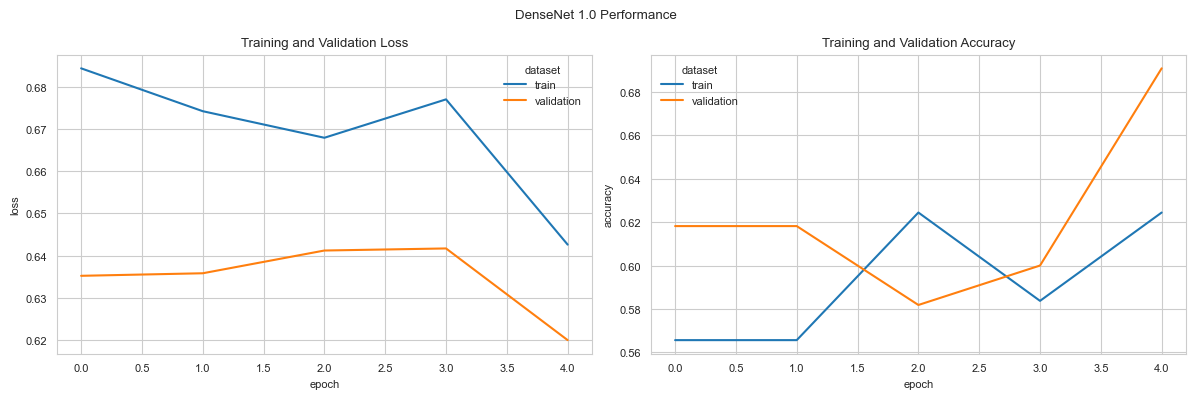

In [7]:
learning_curve(model_name='DenseNet 1.0', history=densenet_1_history)

In [ ]:
densenet_1_history_2 = densenet_1.fit(train_ds_10, epochs=10, initial_epoch=densenet_1_history.epoch[-1], validation_data=val_ds_10, callbacks=[checkpoint_callback])